In [1]:
!pip install networkx 


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 1.3 MB/s eta 0:00:02
   - -------------------------------------- 0.1/1.7 MB 787.7 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.7 MB 819.2 kB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.7 MB 1.2 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.7 MB 1.3 MB/s eta 0:00:02
   ----------- ---------------------------- 0.5/1.7 MB 1.8 MB/s eta 0:00:01
   ----------------- ---------------------- 0.8/1.7 MB 2.4 MB/s eta 0:00:01
   ------------------------ --------------- 1.1/1.7 MB 3.2 MB/s eta 0:00:01
   ----------------------------------- ---- 1.5/1.7 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 4.1 MB/s eta 0:00:00


DEPRECATION: Loading egg at c:\program files\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import nltk
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('omw-1.4')

# Get all senses of 'bank'
senses = wn.synsets('bank')
print(f"Found {len(senses)} senses for 'bank'.")
for idx, sense in enumerate(senses):
    print(f"{idx}: {sense.name()} - {sense.definition()}")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ujwal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ujwal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Found 18 senses for 'bank'.
0: bank.n.01 - sloping land (especially the slope beside a body of water)
1: depository_financial_institution.n.01 - a financial institution that accepts deposits and channels the money into lending activities
2: bank.n.03 - a long ridge or pile
3: bank.n.04 - an arrangement of similar objects in a row or in tiers
4: bank.n.05 - a supply or stock held in reserve for future use (especially in emergencies)
5: bank.n.06 - the funds held by a gambling house or the dealer in some gambling games
6: bank.n.07 - a slope in the turn of a road or track; the outside is higher than the inside in order to reduce the effects of centrifugal force
7: savings_bank.n.02 - a container (usually with a slot in the top) for keeping money at home
8: bank.n.09 - a building in which the business of banking transacted
9: bank.n.10 - a flight maneuver; aircraft tips laterally about its longitudinal axis (especially in turning)
10: bank.v.01 - tip laterally
11: bank.v.02 - enclose with

In [3]:
import networkx as nx

G = nx.Graph()

# Add nodes
for sense in senses:
    G.add_node(sense.name(), definition=sense.definition())

# Add edges based on semantic relationships
for sense in senses:
    for related in sense.hypernyms() + sense.hyponyms() + sense.similar_tos():
        if related.name() in G:
            G.add_edge(sense.name(), related.name())


In [4]:
import torch
import torch.nn as nn

embedding_dim = 768  # Same as BERT's hidden size
sense_embeddings = {sense.name(): torch.randn(embedding_dim) for sense in senses}


In [5]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_context_embedding(sentence, target_word):
    inputs = tokenizer(sentence, return_tensors='pt')
    outputs = bert_model(**inputs)
    token_ids = inputs['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    
    # Find the index of the target word
    try:
        target_index = tokens.index(target_word)
    except ValueError:
        print(f"'{target_word}' not found in tokenized sentence.")
        return None
    
    # Get the embedding for the target word
    embedding = outputs.last_hidden_state[0][target_index]
    return embedding


C:\Users\ujwal\Twin_tower_model\twin_model\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def apply_gnn(graph, embeddings):
    new_embeddings = {}
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if neighbors:
            neighbor_embeddings = torch.stack([embeddings[neighbor] for neighbor in neighbors])
            aggregated = neighbor_embeddings.mean(dim=0)
            new_embeddings[node] = torch.relu(embeddings[node] + aggregated)
        else:
            new_embeddings[node] = embeddings[node]
    return new_embeddings


In [7]:
import torch.nn.functional as F

def compute_similarity(context_embedding, sense_embeddings):
    scores = {}
    for sense, embedding in sense_embeddings.items():
        similarity = F.cosine_similarity(context_embedding.unsqueeze(0), embedding.unsqueeze(0))
        scores[sense] = similarity.item()
    return scores


In [8]:
def predict_sense(sentence, target_word):
    context_embedding = get_context_embedding(sentence, target_word)
    if context_embedding is None:
        return None
    refined_embeddings = apply_gnn(G, sense_embeddings)
    scores = compute_similarity(context_embedding, refined_embeddings)
    predicted_sense = max(scores, key=scores.get)
    return predicted_sense, scores


In [9]:
import matplotlib.pyplot as plt

def visualize_predictions(scores):
    senses = list(scores.keys())
    values = list(scores.values())
    plt.figure(figsize=(10, 6))
    plt.barh(senses, values)
    plt.xlabel('Similarity Score')
    plt.title('Sense Prediction Scores')
    plt.gca().invert_yaxis()
    plt.show()


Predicted Sense: bank.n.05


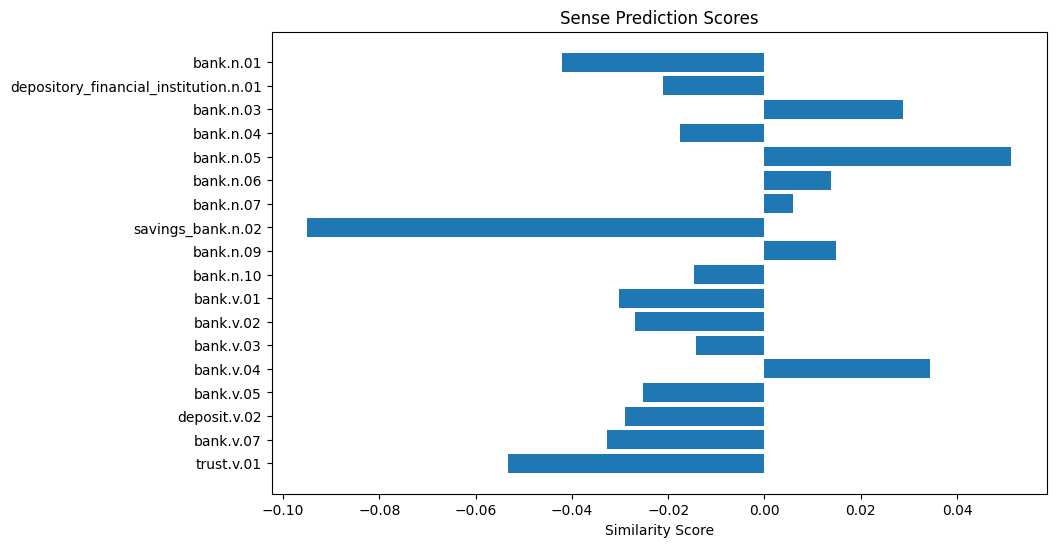

In [10]:
sentence = "He deposited money in the bank."
target_word = "bank"

predicted_sense, scores = predict_sense(sentence, target_word)
print(f"Predicted Sense: {predicted_sense}")
visualize_predictions(scores)


--- Raw Cosine + Lesk Scores ---
bank#1: 0.5616
bank#2: 0.5217
bank#3: 0.4634
bank#4: 0.5349
bank#5: 0.8237


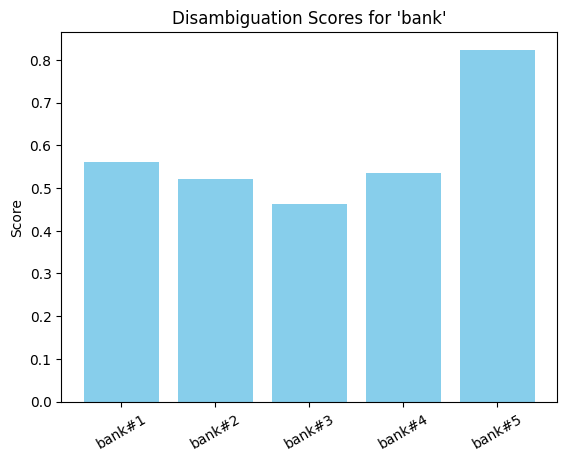


--- Graph Propagated Scores ---
bank#1: 0.5969
bank#2: 0.5042
bank#3: 0.5262
bank#4: 0.5429
bank#5: 0.7304


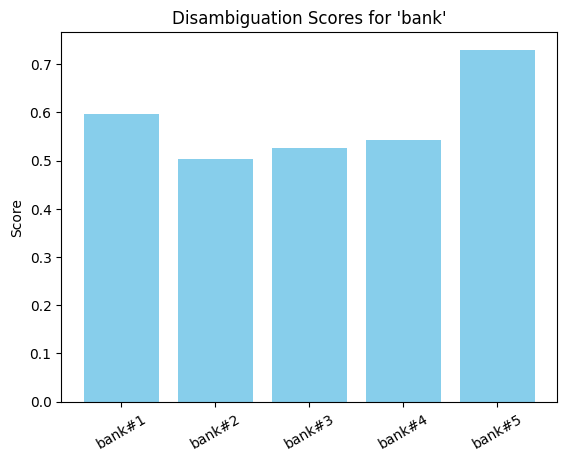

In [11]:
# Knowledge-Graph-Enhanced WSD for 'bank' with modifications

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
import networkx as nx
import matplotlib.pyplot as plt
import re

# Define senses manually (for demo)
senses = {
    'bank#1': 'financial institution that accepts deposits',
    'bank#2': 'land alongside a river',
    'bank#3': 'a slope or mound',
    'bank#4': 'a building used for banking',
    'bank#5': 'a set or series of similar things (e.g. bank of switches)'
}

# Manually defined adjacency graph (simplified WordNet-like structure)
sense_graph = nx.Graph()
sense_graph.add_edges_from([
    ('bank#1', 'bank#4'),
    ('bank#1', 'bank#5'),
    ('bank#2', 'bank#3'),
    ('bank#3', 'bank#5')
])

# BERT for context and gloss encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

# Freeze BERT for faster inference
for param in bert.parameters():
    param.requires_grad = False

# Gloss encoder
def encode_gloss(gloss):
    inputs = tokenizer(gloss, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        output = bert(**inputs).last_hidden_state.mean(dim=1)  # [CLS] token average
    return output.squeeze(0)

# Context encoder
def encode_context(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        output = bert(**inputs).last_hidden_state.mean(dim=1)
    return output.squeeze(0)

# Lesk-style lexical overlap
def lesk_overlap(context, gloss):
    context_words = set(re.findall(r'\w+', context.lower()))
    gloss_words = set(re.findall(r'\w+', gloss.lower()))
    return len(context_words & gloss_words)

# Compute cosine similarity with optional graph propagation and Lesk

def score_senses(context_vec, gloss_vectors, sentence_text, gloss_texts, alpha=0.2, graph=None):
    scores = {}
    for s, gloss_vec in gloss_vectors.items():
        cosine_sim = F.cosine_similarity(context_vec, gloss_vec, dim=0).item()
        overlap_score = lesk_overlap(sentence_text, gloss_texts[s])
        scores[s] = cosine_sim + alpha * overlap_score

    if graph:
        # One-step propagation
        propagated_scores = scores.copy()
        for s in scores:
            neighbors = list(graph.neighbors(s))
            if neighbors:
                neighbor_score = sum(scores[n] for n in neighbors) / len(neighbors)
                propagated_scores[s] = 0.7 * scores[s] + 0.3 * neighbor_score
        return propagated_scores
    return scores

# Visualization
def visualize_scores(scores):
    plt.bar(scores.keys(), scores.values(), color='skyblue')
    plt.ylabel("Score")
    plt.title("Disambiguation Scores for 'bank'")
    plt.xticks(rotation=30)
    plt.show()

# Main demo
if __name__ == '__main__':
    sentence = "He went to the bank to deposit his paycheck."
    context_vec = encode_context(sentence)
    gloss_vectors = {s: encode_gloss(gloss) for s, gloss in senses.items()}

    # Without graph
    print("--- Raw Cosine + Lesk Scores ---")
    raw_scores = score_senses(context_vec, gloss_vectors, sentence, senses, alpha=0.3, graph=None)
    for s, score in raw_scores.items():
        print(f"{s}: {score:.4f}")
    visualize_scores(raw_scores)

    # With graph propagation
    print("\n--- Graph Propagated Scores ---")
    graph_scores = score_senses(context_vec, gloss_vectors, sentence, senses, alpha=0.3, graph=sense_graph)
    for s, score in graph_scores.items():
        print(f"{s}: {score:.4f}")
    visualize_scores(graph_scores)


In [ ]:
t
